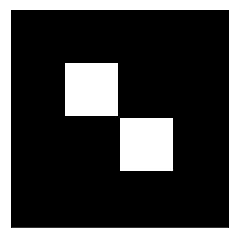

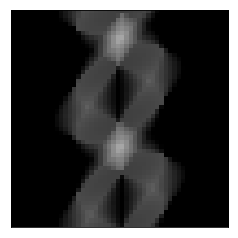

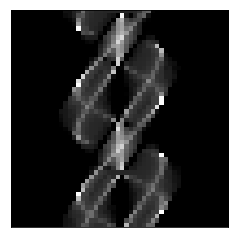

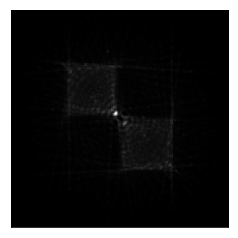

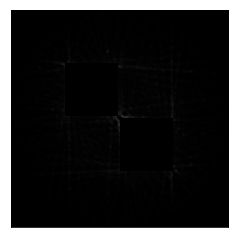

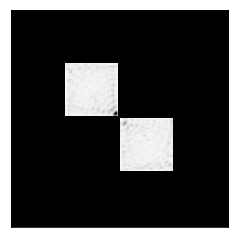

19707.568806966145


In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math as m
import datetime, time
from IPython.display import clear_output
import copy


def load(name):
    im = cv2.imread(name)
    return im

def plot(img):
    tmp = img
    plt.imshow(tmp)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def colorMean(color):
    return (0.11 * color[0] + 0.59 * color[1] + 0.3 * color[2])

def brightenColor(color, brightness):
    color += brightness
    return color
    
def BresenhamLine(img, x1, y1, x2, y2, M):
    x, y = x1, y1
    sum, it = 0, 0
    xi = 1 if x1 < x2 else -1
    dx = xi*(x2 - x1)
    yi = 1 if y1 < y2 else -1
    dy = yi*(y2 - y1)
    
    col = colorMean(img[x][y])
    sum += col
    M[x][y] += 1
    it += 1       
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi   
            col = colorMean(img[x][y])
            sum += col
            M[x][y] += 1
            it += 1
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi             
            col = colorMean(img[x][y])
            sum += col
            M[x][y] += 1
            it += 1          
    return sum / it
    
def normalize(sinog):
    sinogram_max = max(map(max, sinog))
    for i, row in enumerate(sinog):
        for j, el in enumerate(row):
            if sinogram_max != 0:
                sinog[i][j] = sinog[i][j] / sinogram_max * 255
    return sinog

def removeMinus(img):                   
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            if el < 0:
                img[i][j] = 0            
    return img


def convertToUint8RGB(img):
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            el = np.uint8(round(el))
            img[i][j] = [el, el, el]    
    return img

def convolveSinogram(img, kernelSize=9):
    width = len(img)
    imgNew = []
    for i in range(width):
        imgNew.append([])
        for j in range(width):
            imgNew[i].append(0.0) 
            
    kernelCenter = (int)(kernelSize / 2)
    kernel = []
    for i in range(kernelSize):
        if i == kernelCenter:
            kernel.append(1.0)
        elif i % 2 == 0:
            kernel.append(0.0)
        else:
            kernel.append((-4 / pow(m.pi, 2)) / pow(i - kernelCenter, 2))
            
    width = len(img[0])
    for i, row in enumerate(img):
        j = kernelCenter
        while j < (width - kernelCenter):
            it = 0
            k = j - kernelCenter
            while it < kernelSize:
                imgNew[i][j] += img[i][k] * kernel[it]
                k += 1
                it += 1
            j += 1
        
    return imgNew

def animate(img):
    clear_output(wait=True)
    img2 = copy.deepcopy(img)
    img2 = normalize(img2)
    img2 = convertToUint8RGB(img2)
    img2 = np.asarray(img2)
    plot(img2)


def sinogram(img, M, steps=12, l=45, detectors=5, alfa=180, animated=False): 
    alfa = alfa / steps
    alfaRadians = m.radians(alfa)
    center = (int)(img.shape[0] / 2)
    radius = center - 5 
    centerTuple = (center, center)
    tmpRadians = 0
    sinog = []
    for i in range(steps):
        sinog.append([])
    
    for i in range(steps):
        x = center + int(radius * np.cos(tmpRadians))
        y = center + int(radius * np.sin(tmpRadians))
        tmpDetectorRadians = m.radians(180 - l/2) + tmpRadians
        detectorStep = m.radians(l / (detectors - 1))
        for j in range(detectors):
            xDet = center + int(radius * np.cos(tmpDetectorRadians))
            yDet = center + int(radius * np.sin(tmpDetectorRadians))
            tmpDetectorRadians += detectorStep
            sinog[i].append(BresenhamLine(img, x, y, xDet, yDet, M))
            
        tmpRadians += alfaRadians
        
        if animated:
            animate(sinog[:(i+1)])
            
    originalSinog = []
    for i in range(steps):
        originalSinog.append([])
        for j in range(detectors):
            originalSinog[i].append(np.uint16(0))
    for i, row in enumerate(originalSinog):
        for j, el in enumerate(row):
            originalSinog[i][j] = sinog[i][j]
    
    
    originalSinog = convertToUint8RGB(originalSinog)
    originalSinog = np.asarray(originalSinog)
    plot(originalSinog)
    sinog = convolveSinogram(sinog)
    sinog = removeMinus(sinog)
    sinog = normalize(sinog)

    sinog = convertToUint8RGB(sinog)
    sinog = np.asarray(sinog)
    plot(sinog)
    
    return sinog


def bresenhamLineInverse(img, x1, y1, x2, y2, brightness):
    x = x1
    y = y1 
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
        
    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
    img[x][y] = brightenColor(img[x][y], brightness)     
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi  
            img[x][y] = brightenColor(img[x][y], brightness)
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
            img[x][y] = brightenColor(img[x][y], brightness)
            
    return img
    
def convolve(img, kernelSize, animated=False):
    width = len(img)
    imgNew = []
    for i in range(width):
        imgNew.append([])
        for j in range(width):
            imgNew[i].append(0.0) 
            
    kernel = np.ones((kernelSize, kernelSize))
    kernel /= 1.0 * kernelSize * kernelSize
    
    shift = (int)((kernelSize-1) / 2)
    m = shift
    while m < (width - shift):
        n = shift
        while n < (width - shift):
            i = m - shift
            while i <= (m + shift):
                j = n - shift
                while j <= (n + shift):
                    imgNew[m][n] += img[i][j] * kernel[m-i][n-j]
                    j += 1
                i += 1
            n += 1
        m += 1
        
        if animated:
            animate(imgNew)
            
    return imgNew
    
def inverseRadonTransform(img, M, sinog, steps, l, detectors, alfa, kernelSize = 5, animated=False):
    alfa = alfa / steps
    alfaRadians = m.radians(alfa)
    center = (int)(img.shape[0] / 2)
    radius = center - 5 
    centerTuple = (center, center)
    
    height, width, channels = img.shape
    img2 = []
    for i in range(height):
        img2.append([])
        for j in range(width):
            img2[i].append(np.uint16(0))

    tmpRadians = 0
    
    for i in range(steps):
        x = center + int(radius * np.cos(tmpRadians))
        y = center + int(radius * np.sin(tmpRadians))
        tmpDetectorRadians = m.radians(180 - l/2) + tmpRadians
        detectorStep = m.radians(l / (detectors - 1))
        for j in range(detectors):
            xDet = center + int(radius * np.cos(tmpDetectorRadians))
            yDet = center + int(radius * np.sin(tmpDetectorRadians))
            tmpDetectorRadians += detectorStep
            brightness = colorMean(sinog[i][j])
            img2 = bresenhamLineInverse(img2, x, y, xDet, yDet, brightness)

        tmpRadians += alfaRadians
        
    for i, row in enumerate(img2):
        for j, el in enumerate(row):
            if M[i][j] != 0:
                img2[i][j] = el / M[i][j]
    
    img2 = normalize(img2)
    
    for i, row in enumerate(img2):
        for j, el in enumerate(row):
            img2[i][j] = m.pow(el, 2)
            
    img2 = convolve(img2, kernelSize, animated)
    
    for i, row in enumerate(img2):
        for j, el in enumerate(row):
            img2[i][j] = m.pow(el, (3/2))
    
    img2 = normalize(img2)
    img2 = convertToUint8RGB(img2)
    img2 = np.asarray(img2)
    return img2

    
def meanSquaredError(img, img2):
    err = np.sum((img.astype("float") - img2.astype("float")) ** 2)
    err /= float(img.shape[0] * img.shape[1])
    return err

def pictureDifference(img, img2, height, width):
    imgD = []
    for i in range(height):
        imgD.append([])
        for j in range(width):
            imgD[i].append(np.uint16(0))
    for i, row in enumerate(img):
        for j, el in enumerate(row):
            imgD[i][j] = img2[i][j] - img[i][j]
            if img2[i][j][0]<img[i][j][0]:
                imgD[i][j] = img2[i][j] - img2[i][j]
    imgD = np.asarray(imgD)
    return imgD

alfa = 360
steps = 50
l = 300
detectors = 50
kernelSize = 5
animated = False
img = load("kwadraty2.bmp")
plot(img)

width, height, channels = img.shape
M = []
for i in range(width):
    M.append([])
    for j in range(height):
        M[i].append(0)
        
sinog = sinogram(img, M, steps, l, detectors, alfa, animated)
newImg = inverseRadonTransform(img, M, sinog, steps, l, detectors, alfa, kernelSize, animated)
plot(newImg)
err = meanSquaredError(img, newImg)
imgD = pictureDifference(img, newImg, height, width)
plot(imgD)
imgD = pictureDifference(newImg, img , height, width)
plot(imgD)
print(err)